# Compare the discriminative power of PWMs VS *k*-mer-based motif models

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc
from typing import Dict, List, Optional
from numpy.random import permutation
from glob import glob
from _io import TextIOWrapper

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 

import time
import sys
import re
import os

## Define paths to data and constant variables

In [7]:
data_path = "/Users/manuel/Desktop/MotifRaptor/data"
TFS = ["NFKB1", "RUNX3", "STAT1"]
NUCSMAP = {"A": 0, "C": 1, "G": 2, "T": 3}

## Define functions used throughout the analysis

In [3]:
def print_progress(progress: int, total: int) -> None:
    assert isinstance(progress, int)
    assert isinstance(total, int)
    assert progress <= total
    print("Progress %.2f%%" % ((progress / total) * 100), end="\r")

In [4]:
def compute_reverse(seq: str) -> str:
    assert isinstance(seq, str)
    rv = {"A": "T", "C": "G", "G": "C", "T": "A", "N": "N"}
    reverse = []
    for nt in seq:
        try:
            nt_rev = rv[nt]
        except KeyError as e:
            raise e
        reverse.append(nt_rev)
    reverse = "".join(reverse)
    assert bool(reverse)
    return reverse

In [5]:
def read_fasta(infasta: str) -> Dict[str, str]:
    assert isinstance(infasta, str)
    assert os.path.isfile(infasta)
    fdict = {}
    try:
        handle = open(infasta, mode="r")
        while True:
            line = handle.readline().strip()
            if not line:
                break
            if line.startswith(">"):
                if line in fdict.keys():
                    handle.readline()  # consume the buffer (sequence)
                    continue
                seqname = line
                continue  # read the sequence
            assert seqname not in fdict.keys()
            fdict[seqname] = line.upper()
            fdict["_".join([seqname, "rev"])] = compute_reverse(fdict[seqname])
    except OSError as e:
        raise e
    finally:
        handle.close()
    assert bool(fdict)
    return fdict

In [20]:
def shuffle_sequences(
    fastadict: Dict[str, str], perms: Optional[int] = 2
) -> Dict[str, str]:
    assert isinstance(fastadict, dict)
    bgseqs = {}
    for i,seqname in enumerate(fastadict.keys()):
        seq = fastadict[seqname]
        for _ in range(perms):
            bgseqs[f">random{i + 1}"] = "".join(
                [seq[i] for i in permutation(len(seq))]
            )
    assert bool(bgseqs)
    return bgseqs

In [15]:
def read_motif(motif_file: str) -> np.ndarray:
    assert isinstance(motif_file, str)
    assert os.path.isfile(motif_file)
    counts = []
    try:
        handle = open(motif_file, mode="r")
        for line in handle:
            counts.append(list(map(float, line.strip().split())))
    except OSError as e:
        raise e
    finally: handle.close()
    motif = np.array(counts)
    motif = (motif + 0.001) / (motif + 0.001).sum(0)
    motif = (motif.T / np.array([0.2951, 0.2047, 0.2048,0.2955])).T
    motif = np.log2(motif)
    return motif

In [27]:
def read_kmers(kmers_file: str) -> Dict[str, float]:
    assert isinstance(kmers_file, str)
    assert os.path.isfile(kmers_file)
    kmers_weights = {}
    try:
        handle = open(kmers_file, mode="r")
        while True:
            line = handle.readline().strip()
            if not line:
                break
            kmer, weight = line.split()
            kmers_weights[kmer] = float(weight)
    except OSError as e:
        raise e
    finally:
        handle.close()
    return kmers_weights

In [8]:
def score_sequence(seq: str, motif: np.ndarray, width: int) -> int:
    assert isinstance(seq, str)
    assert isinstance(motif, np.ndarray)
    assert isinstance(width, int)
    seq_len = len(seq)
    scores = []
    for i in range(0, (seq_len - width + 1)):
        kmer = seq[i:(i + width)]
        sequence_score = 0
        for j, nt in enumerate(kmer):
            if nt == "N":
                sequence_score = motif.min() * width
                break
            idx = NUCSMAP[nt]
            sequence_score += motif[idx, j]
        scores.append(sequence_score)
    sequence_score = np.array(scores).max()
    return sequence_score

In [21]:
def build_dataset_pwm(
    fdict_fg: Dict[str, str], fdict_bg: Dict[str, str], motif: np.ndarray
) -> pd.DataFrame:
    assert isinstance(fdict_fg, dict)
    assert isinstance(fdict_bg, dict)
    assert isinstance(motif, np.ndarray)
    width = motif.shape[1]
    progress = 0
    print_progress(
        progress, len(fdict_fg.keys()) + len(fdict_bg.keys())
    )
    # foreground
    X_fg = pd.DataFrame(
        data=np.nan, index=list(fdict_fg.keys()), columns=["SCORE"]
    )
    for seqname in fdict_fg.keys():
        seq = fdict_fg[seqname]
        X_fg.loc[seqname, "SCORE"] = score_sequence(seq, motif, width)
        progress += 1
        print_progress(
            progress, len(fdict_fg.keys()) + len(fdict_bg.keys())
        )
    X_fg["PEAK"] = 1
    # background
    X_bg = pd.DataFrame(
        data=np.nan, index=list(fdict_bg.keys()), columns=["SCORE"]
    )
    for seqname in fdict_bg.keys():
        seq = fdict_bg[seqname]
        X_bg.loc[seqname, "SCORE"] = score_sequence(seq, motif, width)
        progress += 1
        print_progress(
            progress, len(fdict_fg.keys()) + len(fdict_bg.keys())
        )
    X_bg["PEAK"] = 0
    # construct the final dataset
    X = pd.concat([X_fg, X_bg])
    assert not X.empty
    return X

In [ ]:
def score_sequence_kmers(
    sequence: str, kmers_weights: Dict[str, str], k: int
) -> float:
    n = len(sequence)
    min_value = np.min(list(kmers_weights.values()))
    score = 0
    for i in range(n - k + 1):
        kmer = sequence[i:(i + k)]
        try:
            score += kmers_weights[kmer]
        except KeyError:
            score += min_value
    return score

In [36]:
def build_dataset_kmers(
    fdict_fg: Dict[str, str], 
    fdict_bg: Dict[str, str], 
    kmers_file: str,
) -> pd.DataFrame:
    assert isinstance(fdict_fg, dict)
    assert isinstance(fdict_bg, dict)
    assert isinstance(kmers_file, str)
    assert os.path.isfile(kmers_file)
    progress = 0
    print_progress(
        progress, len(fdict_fg.keys()) + len(fdict_bg.keys())
    )
    kmers_weights = read_kmers(kmers_file)
    k = len(list(kmers_weights.keys())[0])
    assert all([len(kmer) == k for kmer in kmers_weights.keys()])
    X_fg = pd.DataFrame(
        data=np.nan, index=list(fdict_fg.keys()), columns=["SCORE"]
    )
    for seqname in fdict_fg:
        sequence = fdict_fg[seqname]
        X_fg.loc[seqname, "SCORE"] = score_sequence_kmers(sequence, kmers_weights, k)
        progress += 1
        print_progress(
            progress, len(fdict_fg.keys()) + len(fdict_bg.keys())
        )
    X_fg ["PEAK"] = 1
    X_bg = pd.DataFrame(
        data=np.nan, index=list(fdict_bg.keys()), columns=["SCORE"]
    )
    for seqname in fdict_bg:
        sequence = fdict_bg[seqname]
        X_bg.loc[seqname, "SCORE"] = score_sequence_kmers(
            sequence, kmers_weights, k
        )
        progress += 1
        print_progress(
            progress, len(fdict_fg.keys()) + len(fdict_bg.keys())
        )
    X_bg ["PEAK"] = 0
    # construct the final dataset
    X = pd.concat([X_fg, X_bg])
    assert not X.empty
    return X

In [40]:
def plot_precision_recall_curve(
    precision: np.array, 
    recall: np.array, 
    auc: float, 
    tf: str,
    pwm: Optional[bool] = True
) -> None:
    f, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.plot(recall, precision, marker=".")
    ax.set_xlabel("Recall", size=16)
    ax.set_ylabel("Precision", size=16)
    ax.text(0.8, 0.9, "AUC = %.2f" % (auc), fontsize=14)
    if pwm:
        title = f"{tf} - (PWM)"
    else:
        title = f"{tf} - (k-mers)"
    ax.set_title(title, size=18)

## Start the analysis

### Assess PWMs' discriminative power

In [17]:
# build motif library
motifs_library = {}
for tf in TFS:
    motif_file = os.path.join(data_path, f"{tf}.pfm")
    motif = read_motif(motif_file)
    motifs_library[tf] = motif
motifs_library

{'NFKB1': array([[-13.45313948, -13.45313948,  -3.48591322,   1.1565587 ,
           0.76064825,  -0.67979419,  -3.48591322,  -2.48663403,
          -2.48663403, -13.45313948],
        [-12.92544666, -12.92544666, -12.92544666, -12.92544666,
           0.74088831,  -2.9582204 ,  -1.95894121,   1.12788533,
           2.16966186,   2.2103027 ],
        [  2.28759849,   2.28759849,   2.24912537,   0.7401837 ,
          -2.95892501,  -1.37492367,  -1.95964582, -12.92615127,
         -12.92615127, -12.92615127],
        [-13.45509369, -13.45509369, -13.45509369, -13.45509369,
          -1.1670928 ,   1.26563153,   1.55512843,   0.75869404,
          -3.48786743,  -2.48858824]]),
 'RUNX3': array([[  0.81067857,   1.20850061,   1.65089643,  -9.55300134,
         -21.10781281,   0.38659716,  -6.26418342,   1.62486997,
           1.18422516,   0.87458667],
        [ -0.04489317,  -1.72777783,  -2.34932056,   2.28784974,
           2.28426587,  -4.38417621,   2.25517229,  -2.22247291,
          

In [24]:
# compute random genomic sequences through shuffling
datasets = {}
for tf in TFS:
    print(f"Starting task on {tf}...")
    start = time.time()
    fastafile = os.path.join(data_path, f"{tf}_no22.fa")
    fdict_fg = read_fasta(fastafile)
    fdict_bg = shuffle_sequences(fdict_fg)
    motif = motifs_library[tf]
    X = build_dataset_pwm(fdict_fg, fdict_bg, motif)
    datasets[tf] = X
    stop = time.time()
    print("Task completed on %s in %.2fs" % (tf, (stop - start)))
datasets

Starting task on NFKB1...
Task completed on NFKB1 in 326.12s
Starting task on RUNX3...
Task completed on RUNX3 in 47.14s
Starting task on STAT1...
Task completed on STAT1 in 4.06s


{'NFKB1':                                    SCORE  PEAK
 >chr20:42033547-42033805       17.070139     1
 >chr20:42033547-42033805_rev   10.804613     1
 >chr3:125461778-125462003      17.070139     1
 >chr3:125461778-125462003_rev  11.716277     1
 >chr21:46524530-46524767       16.700948     1
 >chr21:46524530-46524767_rev    7.891071     1
 >chr2:151377792-151378110      15.124713     1
 >chr2:151377792-151378110_rev   3.285032     1
 >chr12:90354002-90354257       17.050379     1
 >chr12:90354002-90354257_rev   -1.413858     1
 >chr12:8782097-8782493         17.050379     1
 >chr12:8782097-8782493_rev      3.258313     1
 >chr4:69487998-69488508        15.124713     1
 >chr4:69487998-69488508_rev     0.039704     1
 >chr11:8405809-8406070         11.241453     1
 >chr11:8405809-8406070_rev      1.506616     1
 >chr7:155608025-155608313      15.124713     1
 >chr7:155608025-155608313_rev   5.668969     1
 >chr1:147112624-147112956      17.070139     1
 >chr1:147112624-147112956_rev 

Starting task on NFKB1...
Task completed on NFKB1 in 4.67s
Starting task on RUNX3...
Task completed on RUNX3 in 0.77s
Starting task on STAT1...
Task completed on STAT1 in 0.13s


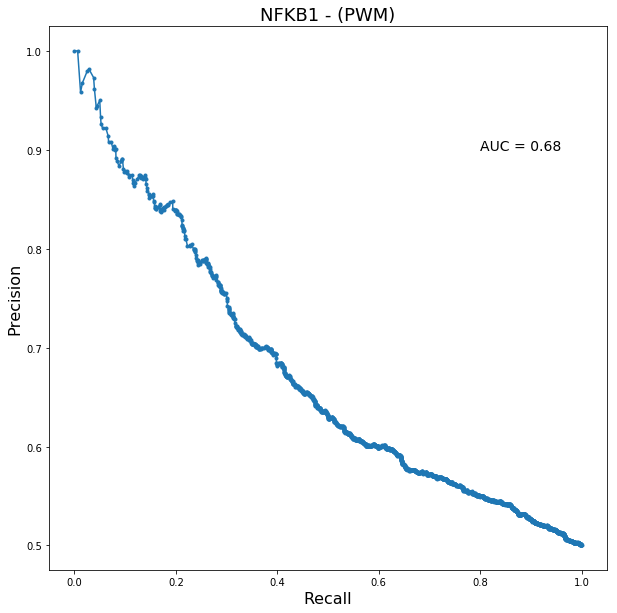

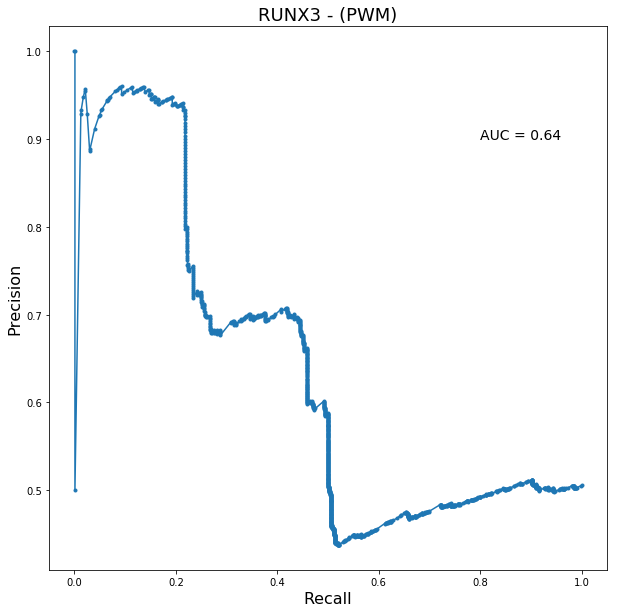

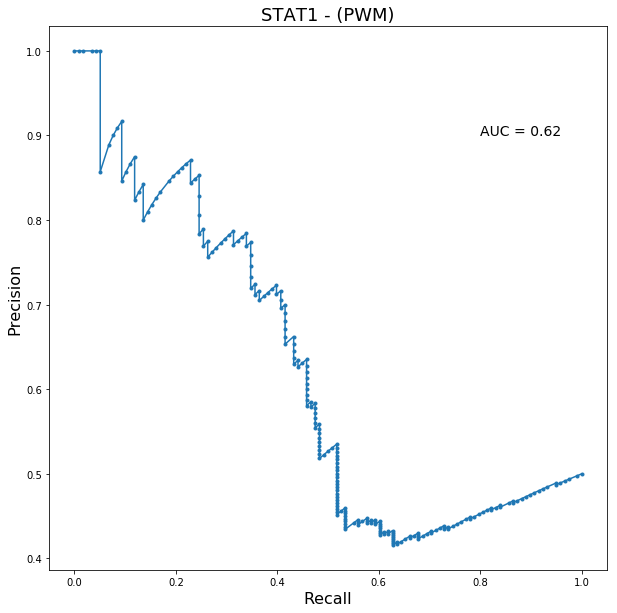

In [26]:
for tf in TFS:
    print(f"Starting task on {tf}...")
    start = time.time()
    X_train = datasets[tf].copy()
    Y_train = X_train["PEAK"]
    X_train.drop(["PEAK"], axis=1, inplace=True)
    fastafile = os.path.join(data_path, f"{tf}_22.fa")
    fdict_fg = read_fasta(fastafile)
    fdict_bg = shuffle_sequences(fdict_fg)
    motif = motifs_library[tf]
    X_test = build_dataset_pwm(fdict_fg, fdict_bg, motif)
    Y_test = X_test["PEAK"]
    X_test.drop(["PEAK"], axis=1, inplace=True)
    clf = LogisticRegression(random_state=0, max_iter=10000, solver="lbfgs")
    clf.fit(X_train, Y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    precision, recall, _ = precision_recall_curve(Y_test, probs)
    auc_val = auc(recall, precision)
    # plot PR-curve
    plot_precision_recall_curve(precision, recall, auc_val, tf)
    stop = time.time()
    print("Task completed on %s in %.2fs" % (tf, (stop - start)))

### Assess *k*-mer-based model discriminative power

In [38]:
# compute random genomic sequences through shuffling
datasets = {}
for tf in TFS:
    print(f"Starting task on {tf}...")
    start = time.time()
    fastafile = os.path.join(data_path, f"{tf}_no22.fa")
    kmers_file = os.path.join(data_path, f"{tf}_no22.weights.txt")
    fdict_fg = read_fasta(fastafile)
    fdict_bg = shuffle_sequences(fdict_fg)
    X = build_dataset_kmers(fdict_fg, fdict_bg, kmers_file)
    datasets[tf] = X
    stop = time.time()
    print("Task completed on %s in %.2fs" % (tf, (stop - start)))
datasets

Starting task on NFKB1...
Task completed on NFKB1 in 25870.59s
Starting task on RUNX3...
Task completed on RUNX3 in 4144.18s
Starting task on STAT1...
Task completed on STAT1 in 361.56s


{'NFKB1':                                     SCORE  PEAK
 >chr20:42033547-42033805        844.59174     1
 >chr20:42033547-42033805_rev    823.45692     1
 >chr3:125461778-125462003       750.75175     1
 >chr3:125461778-125462003_rev   724.54665     1
 >chr21:46524530-46524767        765.04007     1
 >chr21:46524530-46524767_rev    756.43958     1
 >chr2:151377792-151378110      1051.36479     1
 >chr2:151377792-151378110_rev  1032.09203     1
 >chr12:90354002-90354257        846.03359     1
 >chr12:90354002-90354257_rev    802.55679     1
 >chr12:8782097-8782493         1301.58428     1
 >chr12:8782097-8782493_rev     1255.81162     1
 >chr4:69487998-69488508        1680.24739     1
 >chr4:69487998-69488508_rev    1655.92256     1
 >chr11:8405809-8406070          869.32021     1
 >chr11:8405809-8406070_rev      858.39724     1
 >chr7:155608025-155608313       945.11065     1
 >chr7:155608025-155608313_rev   936.92224     1
 >chr1:147112624-147112956      1114.66103     1
 >chr1:1471

Starting task on NFKB1...
Task completed on NFKB1 in 140.40s
Starting task on RUNX3...
Task completed on RUNX3 in 78.71s
Starting task on STAT1...
Task completed on STAT1 in 9.52s


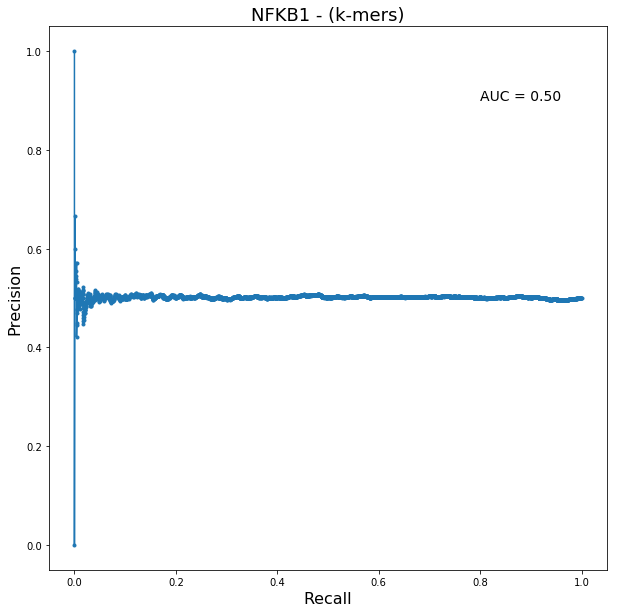

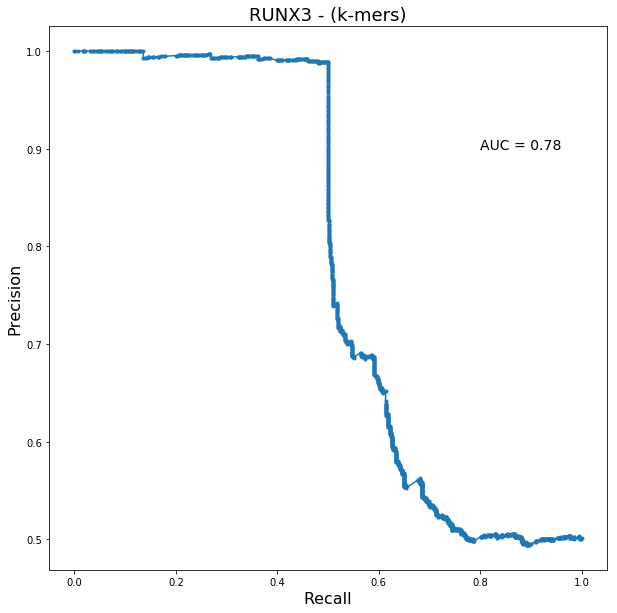

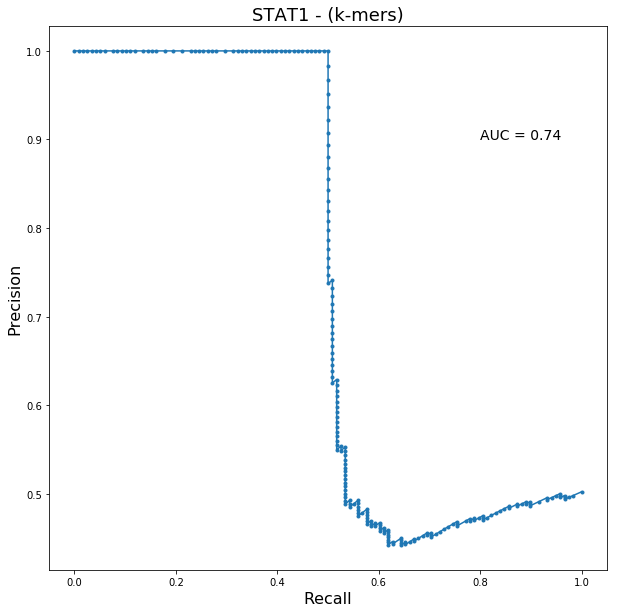

In [41]:
for tf in TFS:
    print(f"Starting task on {tf}...")
    start = time.time()
    X_train = datasets[tf].copy()
    Y_train = X_train["PEAK"]
    X_train.drop(["PEAK"], axis=1, inplace=True)
    fastafile = os.path.join(data_path, f"{tf}_22.fa")
    fdict_fg = read_fasta(fastafile)
    fdict_bg = shuffle_sequences(fdict_fg)
    kmers_file = os.path.join(data_path, f"{tf}_no22.weights.txt")
    X_test = build_dataset_kmers(fdict_fg, fdict_bg, kmers_file)
    Y_test = X_test["PEAK"]
    X_test.drop(["PEAK"], axis=1, inplace=True)
    clf = LogisticRegression(random_state=0, max_iter=10000, solver="lbfgs")
    clf.fit(X_train, Y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    precision, recall, _ = precision_recall_curve(Y_test, probs)
    auc_val = auc(recall, precision)
    # plot PR-curve
    plot_precision_recall_curve(precision, recall, auc_val, tf, pwm=False)
    stop = time.time()
    print("Task completed on %s in %.2fs" % (tf, (stop - start)))